# Project Description
What goes here: updated project schedule (any changes in plans?). What will go into the final analysis? Any deviations from the initial plan.

# Data Description
What goes here: elaborated data description, acquisition, cleaning. Any deviations from the initial project plan?

# Ethical Data Concerns


# Methods


# Preliminary Results

In [ ]:
# Import useful modules
import pyodbc
import pandas as pd
import os
import warnings

# NOTE: dates are formatted month/day/year
#       time is in UTC zulu format
#       wind velocity and gust speed are in knots
#       it doesn't look like wx_int_precip is used
#       the amount of fuel on board is in gallons

def Get_Aviation_Data(db_name):
    """Retrieves desired data from the Microsoft Access Databases 'avall' and 'Pre2008' and returns it in a pandas dataframe."""

    # Determine the current directory
    current_dir = os.getcwd()

    # Connect to the database
    conn_str = (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
                fr'DBQ={current_dir}\{db_name};')
    conn = pyodbc.connect(conn_str)

    if db_name == 'avall.mdb' or db_name == 'Pre2008.mdb':

        # Make arrays of the columns we want from the "events" and "aircraft" tables
        events_columns = ['ev_id', 'ev_date', 'ev_time', 'latitude', 'longitude', 'mid_air', 'on_ground_collision', 'light_cond', 'sky_ceil_ht', 'wind_vel_kts', 'gust_kts', 'altimeter', 'wx_int_precip', 'ev_highest_injury']

        if db_name == 'avall.mdb':
            aircraft_columns = ['ev_id', 'fuel_on_board', 'acft_model', 'acft_make', 'damage']
        else:
            aircraft_columns = ['ev_id', 'acft_model', 'acft_make', 'damage'] 
            # NOTE: Pre2008 doesn't have 'fuel_on_board'

        #  Read in the entire tables for tables that have more than one column (reading in only the columns needed didn't work)
        events_df = pd.read_sql("SELECT * FROM events", conn)
        aircraft_df = pd.read_sql("SELECT * FROM aircraft", conn)

        # Read in the columns from the tables that only have one or two columns
        inj_person_count = pd.read_sql("SELECT inj_person_count FROM injury", conn)
        altitude = pd.read_sql("SELECT Altitude FROM Occurrences", conn)
        finding_description = pd.read_sql("SELECT finding_description FROM Findings", conn)

        # Keep only the desired columns
        events_df = events_df[events_columns]
        aircraft_df = aircraft_df[aircraft_columns]

        # Join the dataframes
        dataframe = events_df.join(aircraft_df, lsuffix='_left', rsuffix='_right')

        # Add the columns that were read in on their own
        dataframe['inj_person_count'] = inj_person_count
        dataframe['altitude'] = altitude
        dataframe['finding_description'] = finding_description

    else:
        # Make arrays of the columns we want from the 'tblFirstHalf', 'tblSecondHalf', and 'ct_Pre1982' tables
        tblFirstHalf_columns = ["RecNum", 'DATE_OCCURRENCE', 'TIME_OCCUR', 'LOCATION','LIGHT_COND', 'ALT_OF_OCC', 'ACFT_MODEL', 'ACFT_MAKE', 'ACFT_ADAMG', 'ACCIDENT_TYPE1', 'ACCIDENT_TYPE2',
                                'GRAND_TOTAL_FATAL', 'GRAND_TOTAL_SERIOUS', 'GRAND_TOTAL_MINOR', 'GRAND_TOTAL_NONE']
        tblSecondHalf_columns = ["RecNum", 'CEILING', 'WIND_VELOCITY', 'PRECIPITATION', 'CAUSE'] 
        ct_Pre1982_names = ['ACCIDENT_TYPE', 'CAUSE_FACTOR', 'OPERATION_PHASE', 'PRECIPITATION', 'ACFT_ADAMG', 'LIGHT_COND', 'LOCAT_STATE_TERR']
        tblOcurrances_columns = ["RecNum", 'Altitude', 'PhaseOfFlight']
        # NOTE: the closest I found to 'wx_int_precip' was 'Precipitation' (Precipitation from the ct_Pre1982 table has the codes),
        #       the closest I found to 'latitude' and 'longitude' is 'location' (locat_state_terr has codes), 
        #       the closest I found to 'ev_highest_injury' and 'inj_person_count' were actually four different columns: 'grand_total_fatal', 'grand_total_serious', 'grand_total_minor', 'grand_total_none' 
        #       the closest I found to 'finding_description' was three different columns: 'Accident_Type1' & 'Accident_Type2' (Accident_Type has codes) and 'Cause' (cause_factor has codes)
        #       the closest I found to 'on_ground_collision' is 'PhaseOfFlight' (operation_phase has the codes)
        #       didn't find anything that matched 'fuel_on_board', 'altimeter', or 'gust_kts'
        #       Items with the same RecNum or ev_id are from the same event
        #       I couldn't join the tables so that the RecNum or ev_id columns merged, so there's two columns for each - with suffixes '_left' and '_right'. YOU SHOULD DROP THESE

        # Read in each table
        tblFirstHalf = pd.read_sql("SELECT * FROM tblFirstHalf", conn)
        tblSeconfHalf = pd.read_sql("SELECT * FROM tblSecondHalf", conn)
        ct_Pre1982 = pd.read_sql("SELECT * FROM ct_Pre1982", conn)
        tblOcurrances = pd.read_sql("SELECT * FROM tblOccurrences", conn)

        # set the index to be the 'Name' column, that way my code works
        ct_Pre1982.set_index('Name', inplace = True)

        # Keep only the desired columns
        tblFirstHalf = tblFirstHalf[tblFirstHalf_columns]
        tblSeconfHalf = tblSeconfHalf[tblSecondHalf_columns]
        ct_Pre1982 = ct_Pre1982.loc[ct_Pre1982_names]
        tblOcurrances = tblOcurrances[tblOcurrances_columns]

        # Join the dataframes
        main_df1 = tblFirstHalf.join(tblSeconfHalf, lsuffix='_left', rsuffix='_right')
        main_df2 = main_df1.join(tblOcurrances, lsuffix='_left', rsuffix='_right')

        # save the file to a csv
        ct_Pre1982.to_csv(fr"{os.getcwd()}\Codes_For_Data_Before_1982.csv", mode = 'x')
        main_df2.to_csv(fr"{os.getcwd()}\Data_Before_1982.csv", mode = 'x')
        dataframe = main_df2

    # Return the dataframe
    return dataframe

'''# Read in the data and ignore the warnings (they're annoying)
with warnings.catch_warnings(action="ignore"):
    df_pre_1982 = Get_Aviation_Data("PRE1982.mdb")
    df_1982_to_2008 = Get_Aviation_Data("Pre2008.mdb")
    df_2008_to_2025 = Get_Aviation_Data("avall.mdb")

# Combine the dataframes with similar columns so that I can use DataFrame.to_csv()
post_1982 = pd.concat([df_1982_to_2008, df_2008_to_2025])

# Save the dataframes to CSV files so that the data can be accessed without needing to download and install Microsoft Access
post_1982.to_csv(fr"{os.getcwd()}\Data_Starting_1982.csv", mode = 'x')'''
# NOTE: I commented out this code so it doesn't give you any weird errors

In [2]:
import pandas as pd  # TODO remove this library
#TODO move all these libraries to above code block,  for now i m keeping as separate to run my code.
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [3]:
aircraft_files = ['Data_Starting_1982.csv', 'Data_Before_1982.csv', 'Codes_For_Data_Before_1982.csv']

# Reading CSV files
data_start_1982 = pd.read_csv(aircraft_files[0])
data_before_1982 = pd.read_csv(aircraft_files[1])
data_codes_before_1982 = pd.read_csv(aircraft_files[2])

columns_to_remove = ['Unnamed: 0', 'RecNum_right','RecNum_left','RecNum']

data_start_1982 = data_start_1982.drop(columns=columns_to_remove[0])
data_before_1982 = data_before_1982.drop(columns=columns_to_remove)


# Checking the first few rows of each dataset
print(data_start_1982.head(5))
print(data_before_1982.head(5))
print(data_codes_before_1982.head(5))

       ev_id_left     ev_date  ev_time latitude longitude mid_air  \
0  20001204X00000  1999-01-10   1730.0  594421N  1615323W     NaN   
1  20001204X00001  1999-01-19    726.0  064541N  0148938W     NaN   
2  20001204X00002  1999-01-05   1825.0  061938N  1495927W     NaN   
3  20001204X00003  1999-01-10   1751.0  604837N  1615058W     NaN   
4  20001204X00004  1999-01-12   1450.0  613151N  0165360W     NaN   

  on_ground_collision light_cond  sky_ceil_ht  wind_vel_kts  ...  \
0                 NaN       DAYL       1000.0           5.0  ...   
1                 NaN       NDRK          0.0           NaN  ...   
2                 NaN       DAYL       2500.0           4.0  ...   
3                 NaN       DAYL        600.0          10.0  ...   
4                 NaN       DAWN        700.0          12.0  ...   

   wx_int_precip  ev_highest_injury     ev_id_right            acft_model  \
0            NaN               MINR  20001204X00000  207                    
1            NaN      

In [4]:
# Inspecting the data info and summary statistics
print(data_start_1982.info())
print(data_before_1982.info())
print(data_codes_before_1982.info())

print(data_start_1982.describe())
print(data_before_1982.describe())
print(data_codes_before_1982.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91517 entries, 0 to 91516
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ev_id_left           91517 non-null  object 
 1   ev_date              91517 non-null  object 
 2   ev_time              90828 non-null  float64
 3   latitude             76861 non-null  object 
 4   longitude            76860 non-null  object 
 5   mid_air              1711 non-null   object 
 6   on_ground_collision  1711 non-null   object 
 7   light_cond           85218 non-null  object 
 8   sky_ceil_ht          91129 non-null  float64
 9   wind_vel_kts         66713 non-null  float64
 10  gust_kts             91230 non-null  float64
 11  altimeter            91129 non-null  float64
 12  wx_int_precip        0 non-null      float64
 13  ev_highest_injury    89828 non-null  object 
 14  ev_id_right          91517 non-null  object 
 15  acft_model           91429 non-null 

In [5]:
# Checking missing values
print("\n Missing Values in Data_Starting_1982")
print(data_start_1982.isnull().sum())

print("\n Missing Values in Data_Before_1982")
print(data_before_1982.isnull().sum())

print("\nMissing values in Codes_For_Data_Before_1982.csv:")
print(data_codes_before_1982.isnull().sum())


 Missing Values in Data_Starting_1982
ev_id_left                 0
ev_date                    0
ev_time                  689
latitude               14656
longitude              14657
mid_air                89806
on_ground_collision    89806
light_cond              6299
sky_ceil_ht              388
wind_vel_kts           24804
gust_kts                 287
altimeter                388
wx_int_precip          91517
ev_highest_injury       1689
ev_id_right                0
acft_model                88
acft_make                 61
damage                  3581
inj_person_count       32826
altitude               28515
finding_description    62988
fuel_on_board          82994
dtype: int64

 Missing Values in Data_Before_1982
DATE_OCCURRENCE            1
TIME_OCCUR                13
LOCATION                   1
LIGHT_COND                34
ALT_OF_OCC             61340
ACFT_MODEL                71
ACFT_MAKE                  2
ACFT_ADAMG                 5
ACCIDENT_TYPE1            29
ACCIDENT_TYP

In [16]:
#  Check for duplicates and remove them
duplicates_start_1982 = data_start_1982.duplicated().sum()  
duplicates_before_1982 = data_before_1982.duplicated().sum()
duplicates_codes = data_codes_before_1982.duplicated().sum()

# Print the number of duplicate rows before removal
print(f"\nNumber of duplicates before removal (1982 onwards): {duplicates_start_1982}")
print(f"Number of duplicates before removal (Before 1982): {duplicates_before_1982}")
print(f"Number of duplicates before removal (Codes Before 1982): {duplicates_codes}")

# Remove duplicates
data_start_1982_clean = data_start_1982.drop_duplicates()
data_before_1982_clean = data_before_1982.drop_duplicates()
data_codes_before_1982_clean = data_codes_before_1982.drop_duplicates()

# After removing duplicates, check how many duplicates remain
duplicates_start_1982_after = data_start_1982_clean.duplicated().sum()
duplicates_before_1982_after = data_before_1982_clean.duplicated().sum()
duplicates_codes_after = data_codes_before_1982_clean.duplicated().sum()

# Printing the number of duplicates remaining after removal
print(f"Number of duplicates after removal (1982 onwards): {duplicates_start_1982_after}")
print(f"Number of duplicates after removal (Before 1982): {duplicates_before_1982_after}")
print(f"Number of duplicates after removal (Codes Before 1982): {duplicates_codes_after}")





Number of duplicates before removal (1982 onwards): 0
Number of duplicates before removal (Before 1982): 1
Number of duplicates before removal (Codes Before 1982): 0
Number of duplicates after removal (1982 onwards): 0
Number of duplicates after removal (Before 1982): 0
Number of duplicates after removal (Codes Before 1982): 0


In [17]:
# Categorical Columns for both data sets 
categorical_columns_start_1982 = data_start_1982.select_dtypes(include=['object', 'category']).columns
categorical_columns_before_1982 = data_before_1982.select_dtypes(include=['object', 'category']).columns

# Numerical Columns for both data sets
numerical_columns_start_1982 = data_start_1982.select_dtypes(include=['int64', 'float64']).columns
numerical_columns_before_1982 = data_before_1982.select_dtypes(include=['int64', 'float64']).columns



# Print the categorized columns for each dataset
print("\nCategorical columns (1982 onwards):", categorical_columns_start_1982)
print("\nCategorical columns (Before 1982):", categorical_columns_before_1982)

print("\nNumerical columns (1982 onwards):", numerical_columns_start_1982)
print("\nNumerical columns (Before 1982):", numerical_columns_before_1982)



Categorical columns (1982 onwards): Index(['ev_id_left', 'ev_date', 'latitude', 'longitude', 'mid_air',
       'on_ground_collision', 'light_cond', 'ev_highest_injury', 'ev_id_right',
       'acft_model', 'acft_make', 'damage', 'finding_description'],
      dtype='object')

Categorical columns (Before 1982): Index(['DATE_OCCURRENCE', 'TIME_OCCUR', 'LOCATION', 'LIGHT_COND', 'ALT_OF_OCC',
       'ACFT_MODEL', 'ACFT_MAKE', 'ACFT_ADAMG', 'ACCIDENT_TYPE1',
       'ACCIDENT_TYPE2', 'CEILING', 'WIND_VELOCITY', 'PRECIPITATION', 'CAUSE',
       'PhaseOfFlight'],
      dtype='object')

Numerical columns (1982 onwards): Index(['ev_time', 'sky_ceil_ht', 'wind_vel_kts', 'gust_kts', 'altimeter',
       'wx_int_precip', 'inj_person_count', 'altitude', 'fuel_on_board'],
      dtype='object')

Numerical columns (Before 1982): Index(['GRAND_TOTAL_FATAL', 'GRAND_TOTAL_SERIOUS', 'GRAND_TOTAL_MINOR',
       'GRAND_TOTAL_NONE', 'Altitude'],
      dtype='object')


In [8]:
# Identify numerical and categorical columns
data_start_numerical_columns = data_start_1982_clean.select_dtypes(include=['float64', 'int64']).columns
data_start_categorical_columns = data_start_1982_clean.select_dtypes(include=['object']).columns

data_before_numerical_columns = data_before_1982_clean.select_dtypes(include=['float64', 'int64']).columns
data_before_categorical_columns = data_before_1982_clean.select_dtypes(include=['object']).columns

# Calculate mean and median for numerical columns
print("\nMean and Median for data_start_1982_clean:")
print("Mean:\n", data_start_1982_clean[data_start_numerical_columns].mean())
print("Median:\n", data_start_1982_clean[data_start_numerical_columns].median())

print("\nMean and Median for data_before_1982_clean:")
print("Mean:\n", data_before_1982_clean[data_before_numerical_columns].mean())
print("Median:\n", data_before_1982_clean[data_before_numerical_columns].median())



Mean and Median for data_start_1982_clean:
Mean:
 ev_time             1525.395539
sky_ceil_ht         1979.521865
wind_vel_kts           8.565272
gust_kts               2.514085
altimeter             23.816850
wx_int_precip               NaN
inj_person_count       2.653115
altitude               0.903178
fuel_on_board        274.843781
dtype: float64
Median:
 ev_time             1730.000000
sky_ceil_ht            0.000000
wind_vel_kts           8.000000
gust_kts               0.000000
altimeter             29.870001
wx_int_precip               NaN
inj_person_count       1.000000
altitude               0.000000
fuel_on_board         38.000000
dtype: float64

Mean and Median for data_before_1982_clean:
Mean:
 GRAND_TOTAL_FATAL        0.054701
GRAND_TOTAL_SERIOUS      0.012569
GRAND_TOTAL_MINOR        0.013787
GRAND_TOTAL_NONE         0.172766
Altitude               459.918105
dtype: float64
Median:
 GRAND_TOTAL_FATAL      0.0
GRAND_TOTAL_SERIOUS    0.0
GRAND_TOTAL_MINOR      0.0
GRAND_T

In [18]:
# Calculate mode for categorical columns
print("\nMode for data_start_1982_clean:")
print(data_start_1982_clean[data_start_categorical_columns].mode().iloc[0])

print("\nMode for data_before_1982_clean:")
print(data_before_1982_clean[data_before_categorical_columns].mode().iloc[0])




Mode for data_start_1982_clean:
ev_id_left                                                20001204X00000
ev_date                                                       1983-06-05
latitude                                                         332739N
longitude                                                       0112457W
mid_air                                                                N
on_ground_collision                                                    Y
light_cond                                                          DAYL
ev_highest_injury                                                   NONE
ev_id_right                                               20001212X19172
acft_model                                          152                 
acft_make                                 CESSNA                        
damage                                                              SUBS
finding_description    Personnel issues-Task performance-Use of equip...
Name: 0, dtype: ob

In [19]:
#Dispersion
# Calculate standard deviation for numerical columns
print("\nStandard Deviation for data_start_1982_clean:")
print(data_start_1982_clean[data_start_numerical_columns].std())

print("\nStandard Deviation for data_before_1982_clean:")
print(data_before_1982_clean[data_before_numerical_columns].std())


Standard Deviation for data_start_1982_clean:
ev_time              693.563613
sky_ceil_ht         5384.591610
wind_vel_kts           5.346715
gust_kts               8.612818
altimeter             87.318444
wx_int_precip               NaN
inj_person_count      16.370997
altitude              70.105335
fuel_on_board       8423.004373
dtype: float64

Standard Deviation for data_before_1982_clean:
GRAND_TOTAL_FATAL         3.116679
GRAND_TOTAL_SERIOUS       0.452387
GRAND_TOTAL_MINOR         0.368946
GRAND_TOTAL_NONE          3.839146
Altitude               2359.667108
dtype: float64


In [11]:
# Calculate variance for numerical columns
#print(data_start_numerical_columns)
print("\nVariance for data_start_1982_clean:")
print(data_start_1982_clean[data_start_numerical_columns].var())

#print(data_before_numerical_columns)
print("\nVariance for data_before_1982_clean:")
print(data_before_1982_clean[data_before_numerical_columns].var())


Variance for data_start_1982_clean:
ev_time             4.810305e+05
sky_ceil_ht         2.899383e+07
wind_vel_kts        2.858736e+01
gust_kts            7.418064e+01
altimeter           7.624511e+03
wx_int_precip                NaN
inj_person_count    2.680096e+02
altitude            4.914758e+03
fuel_on_board       7.094700e+07
dtype: float64

Variance for data_before_1982_clean:
GRAND_TOTAL_FATAL      9.713688e+00
GRAND_TOTAL_SERIOUS    2.046538e-01
GRAND_TOTAL_MINOR      1.361213e-01
GRAND_TOTAL_NONE       1.473904e+01
Altitude               5.568029e+06
dtype: float64


In [12]:
# Function to calculate the 95% confidence interval for each numerical column
def confidence_interval(data, column):
    mean = data[column].mean()
    std = data[column].std()
    n = data[column].count()
    conf_int = stats.t.interval(0.95, n-1, loc=mean, scale=std/np.sqrt(n))
    return conf_int

print("\n95% Confidence Interval for data_start_1982_clean:")
for col in data_start_numerical_columns:
    print(f"{col}: {confidence_interval(data_start_1982_clean, col)}")

print("\n95% Confidence Interval for data_before_1982_clean:")
for col in data_before_numerical_columns:
    print(f"{col}: {confidence_interval(data_before_1982_clean, col)}")


95% Confidence Interval for data_start_1982_clean:
ev_time: (np.float64(1520.8849804949807), np.float64(1529.9060971462752))
sky_ceil_ht: (np.float64(1944.5613089020205), np.float64(2014.4824203169985))
wind_vel_kts: (np.float64(8.524699075453297), np.float64(8.60584519627785))
gust_kts: (np.float64(2.4581957696274714), np.float64(2.569974788303034))
altimeter: (np.float64(23.249916918203585), np.float64(24.38378241241922))
wx_int_precip: (np.float64(nan), np.float64(nan))
inj_person_count: (np.float64(2.520667155951905), np.float64(2.785563782352094))
altitude: (np.float64(0.35574548418162855), np.float64(1.4506098696166636))
fuel_on_board: (np.float64(95.99723409191157), np.float64(453.6903277994412))

95% Confidence Interval for data_before_1982_clean:
GRAND_TOTAL_FATAL: (np.float64(0.03399496757521907), np.float64(0.07540678110637612))
GRAND_TOTAL_SERIOUS: (np.float64(0.009563899161290182), np.float64(0.015574834940298798))
GRAND_TOTAL_MINOR: (np.float64(0.011336116081966009), np.

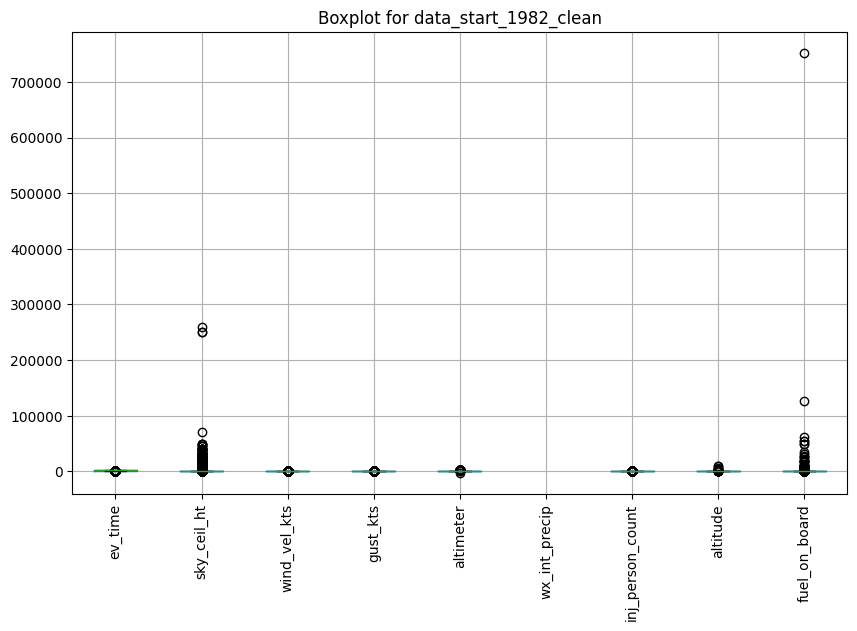

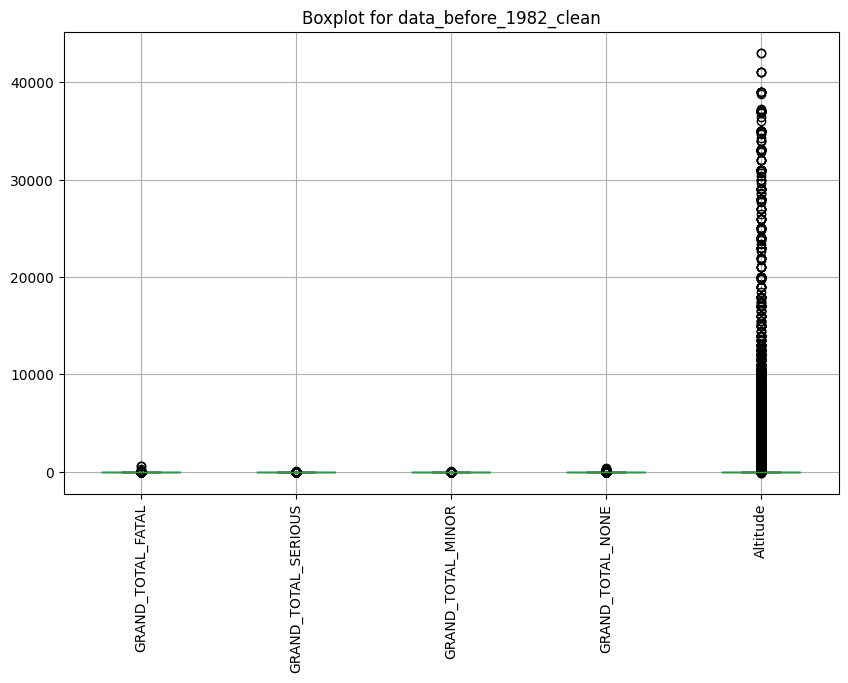

In [20]:
# Boxplot for numerical columns in data_start_1982_clean


plt.figure(figsize=(10, 6))
data_start_1982_clean[data_start_numerical_columns].boxplot()
plt.title("Boxplot for data_start_1982_clean")
plt.xticks(rotation=90)
plt.show()


# Boxplot for numerical columns in data_before_1982_clean
plt.figure(figsize=(10, 6))
data_before_1982_clean[data_before_numerical_columns].boxplot()
plt.title("Boxplot for data_before_1982_clean")
plt.xticks(rotation=90)
plt.show()

In [21]:
# Identify outliers using boxplots
def identify_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

for col in data_start_numerical_columns:
    outliers = identify_outliers(data_start_1982_clean, col)
    print(f"\nOutliers in {col} for data_start_1982_clean: {outliers.shape[0]} rows")

for col in data_before_numerical_columns:
    outliers = identify_outliers(data_before_1982_clean, col)
    print(f"\nOutliers in {col} for data_before_1982_clean: {outliers.shape[0]} rows")


Outliers in ev_time for data_start_1982_clean: 11224 rows

Outliers in sky_ceil_ht for data_start_1982_clean: 21134 rows

Outliers in wind_vel_kts for data_start_1982_clean: 3324 rows

Outliers in gust_kts for data_start_1982_clean: 11111 rows

Outliers in altimeter for data_start_1982_clean: 79 rows

Outliers in wx_int_precip for data_start_1982_clean: 0 rows

Outliers in inj_person_count for data_start_1982_clean: 4282 rows

Outliers in altitude for data_start_1982_clean: 23 rows

Outliers in fuel_on_board for data_start_1982_clean: 773 rows

Outliers in GRAND_TOTAL_FATAL for data_before_1982_clean: 886 rows

Outliers in GRAND_TOTAL_SERIOUS for data_before_1982_clean: 499 rows

Outliers in GRAND_TOTAL_MINOR for data_before_1982_clean: 530 rows

Outliers in GRAND_TOTAL_NONE for data_before_1982_clean: 2006 rows

Outliers in Altitude for data_before_1982_clean: 8055 rows


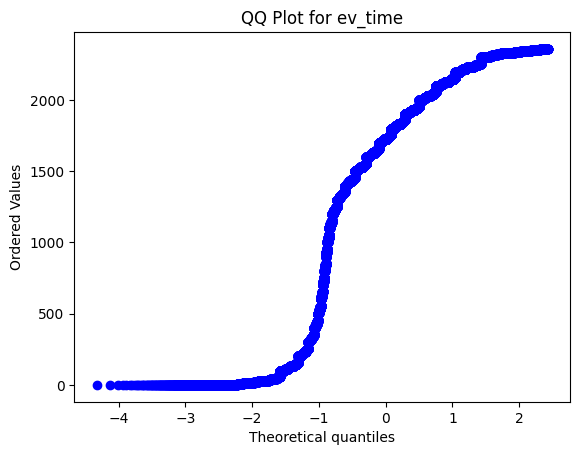

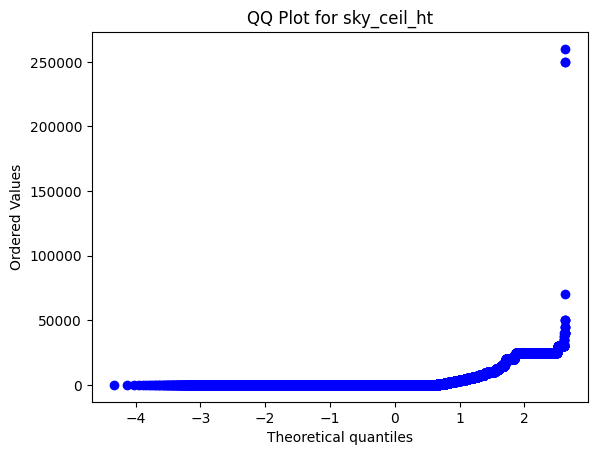

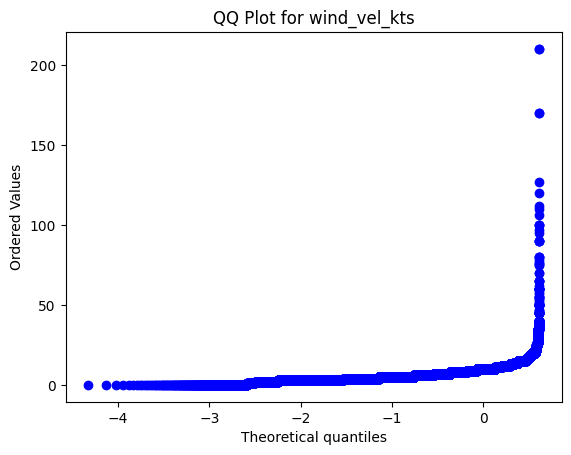

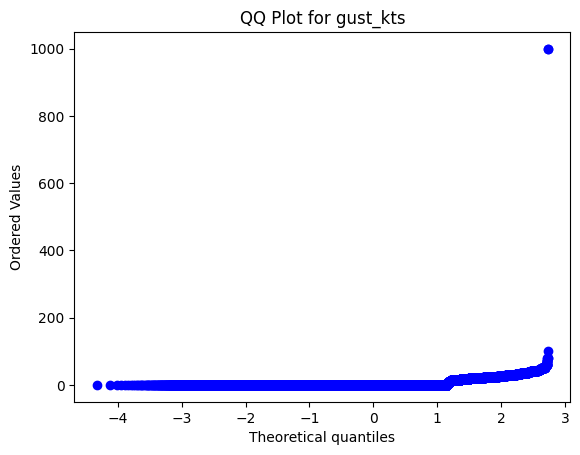

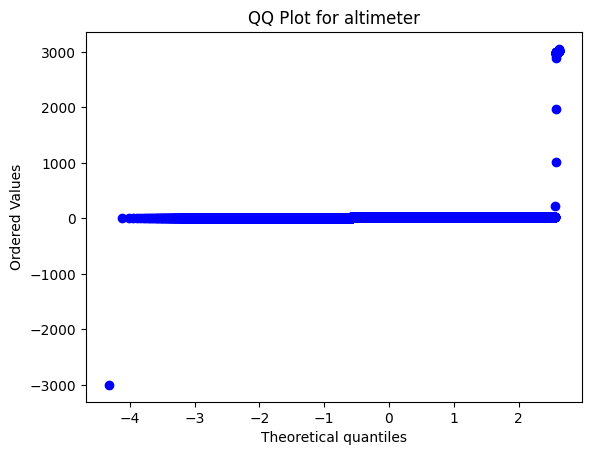

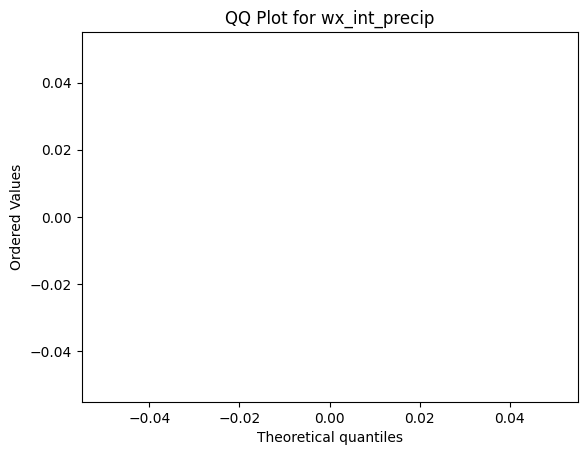

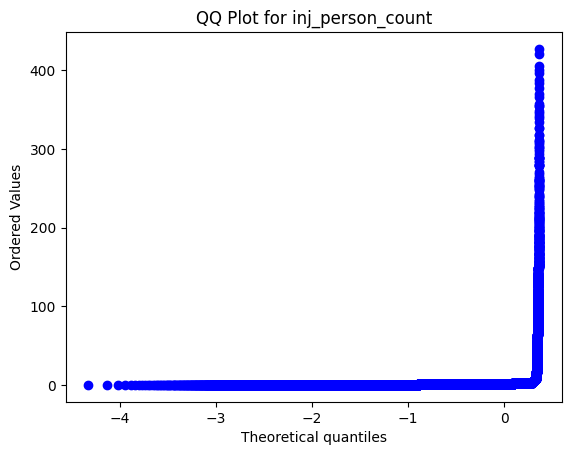

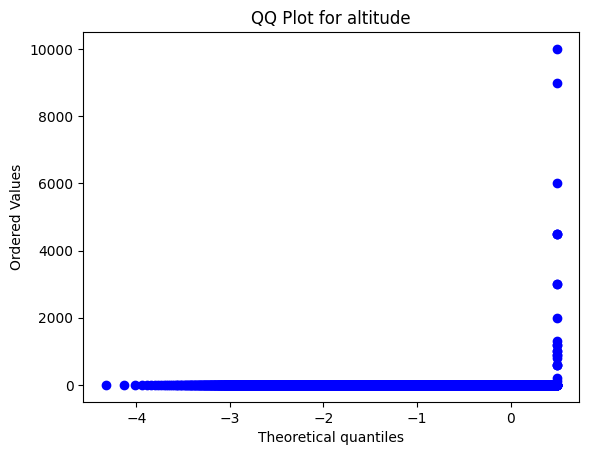

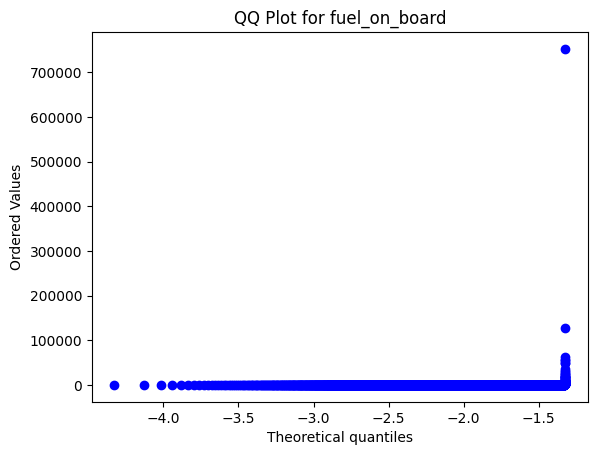

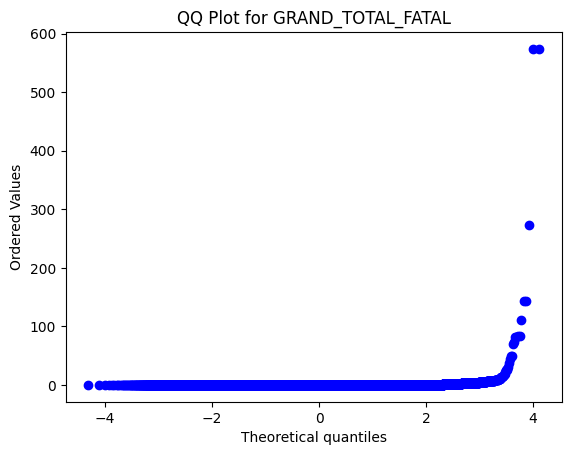

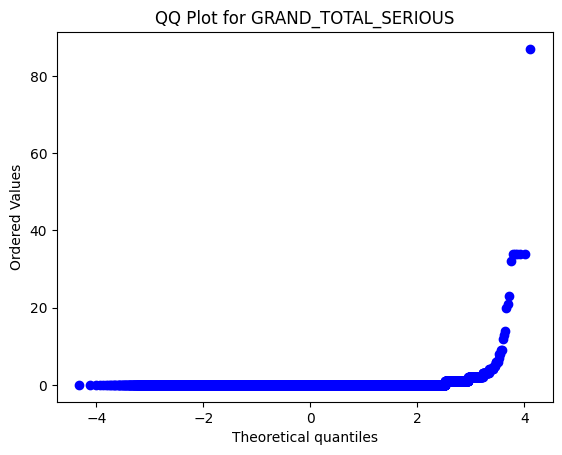

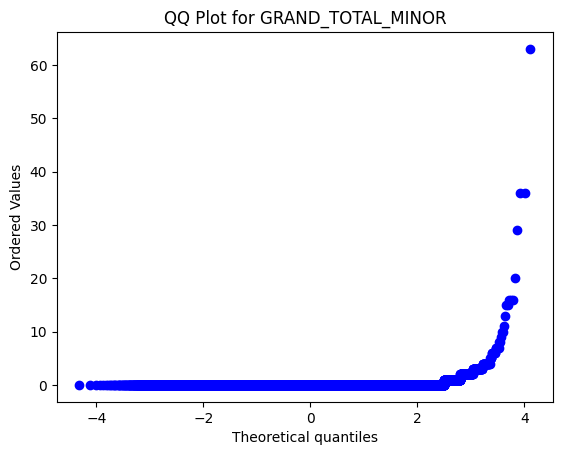

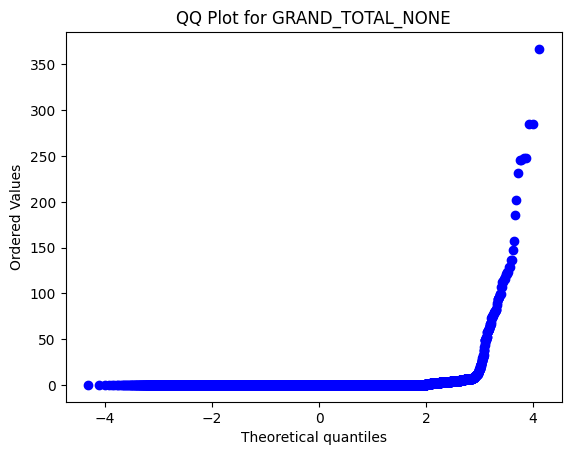

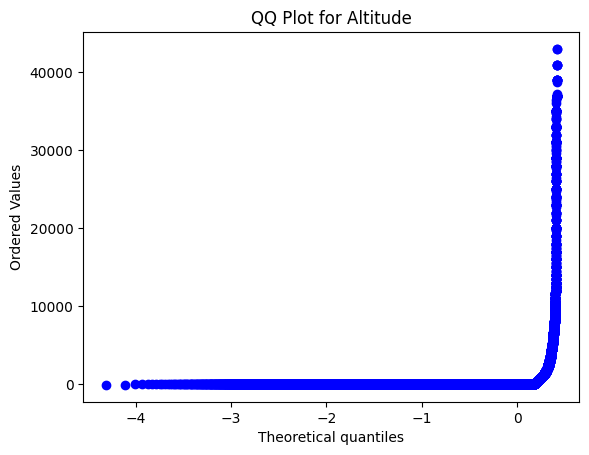

In [15]:
# QQ plot for normality check
def qq_plot(data, column):
    stats.probplot(data[column], dist="norm", plot=plt)
    plt.title(f"QQ Plot for {column}")
    plt.show()

# For data_start_1982_clean
for col in data_start_numerical_columns:
    qq_plot(data_start_1982_clean, col)

# For data_before_1982_clean
for col in data_before_numerical_columns:
    qq_plot(data_before_1982_clean, col)

#### claude ai conversations

**Question:** <br>I run comment#Import useful modules
import pyodbc
import pandas as pd
import os
comment#Determine the paths to the files
current_dir = os.getcwd()
path_older_data = fr"{current_dir}\Pre2008.mdb;"
comment#Read in desired data from the file with data 2008 and more recent
comment#Connect to the database - NOTE: You must NOT have the database open
conn_str = (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
            fr'{current_dir}\avall.mdb;')
conn = pyodbc.connect(conn_str)
comment#Read in the entire tables for tables that have more than one column (reading in only the columns needed didn't work)
events_df = pd.read_sql("SELECT * FROM events", conn)
aircraft_df = pd.read_sql("SELECT * FROM aircraft", conn)
comment#Read in the columns from the tables that only have one or two columns
inj_person_count = pd.read_sql("SELECT inj_person_count FROM injury", conn)
altitude = pd.read_sql("SELECT Altitude FROM Occurrences", conn)
finding_description = pd.read_sql("SELECT finding_description FROM Findings", conn)
comment#Make arrays of the columns we want from the "events" and "aircraft" tables
events_columns = ['ev_date', 'ev_time', 'latitude', 'longitude', 'mid_air', 'on_ground_collision', 'light_cond', 'sky_ceil_ht', 'wind_vel_kts', 'gust_kts', 'altimeter', 'wx_int_precip', 'ev_highest_injury']
aircraft_columns = ['fuel_on_board', 'acft_model', 'acft_make', 'damage']
comment#Keep only the desired columns
events_df = events_df[events_columns]
aircraft_df = aircraft_df[aircraft_columns]
comment#Concatonate the dataframes
df_2008 = events_df.join(aircraft_df)
comment#add the columns that were read in on their own
df_2008['inj_person_count'] = inj_person_count
df_2008['altitude'] = altitude
df_2008['finding_description'] = finding_description
comment#Print the main dataframe
print(df_2008.head())
and get Error: ('01S00', '[01S00] [Microsoft][ODBC Driver Manager] Invalid connection string attribute (0) (SQLDriverConnect)')<br>
**Answer:** <br>You're missing the 'DBQ=' parameter before the file path. Try this: pythonCopyconn_str = (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'fr'DBQ={current_dir}\avall.mdb;')<br>
**Action Taken:** <br>I replaced conn_str = (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'fr'{current_dir}\avall.mdb;') 
with (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'fr'DBQ={current_dir}\avall.mdb;')<br><br><br>

**Question:** <br>Why is this code not working?
comment#Import useful modules
import pyodbc
import pandas as pd
comment#Connect to the database - NOTE: You must NOT have the database open
conn_str = (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
            r'DBQ=C:\Users\erken\Desktop\School Stuff\Intro to Data Science\Intro_To_Data_Science\avall.mdb;')
conn = pyodbc.connect(conn_str)
comment#Read in desired data from the file with data 2008 and more recent
comment#Read in the entire tables for tables that have more than one column (reading in only the columns needed didn't work)
events_df = pd.read_sql("SELECT * FROM events", conn)
aircraft_df = pd.read_sql("SELECT * FROM aircraft", conn)
comment#Read in the columns from the tables that only have one or two columns
inj_person_count = pd.read_sql("SELECT inj_person_count FROM injury", conn)
altitude = pd.read_sql("SELECT Altitude FROM Occurrences", conn)
finding_description = pd.read_sql("SELECT finding_description FROM Findings", conn)
comment#Make arrays of the columns we want from the "events" and "aircraft" tables
events_columns = ['ev_date', 'ev_time', 'latitude', 'longitude', 'mid_air', 'on_ground_collision', 'light_cond', 'sky_ceil_ht', 'wind_vel_kts', 'gust_kts', 'altimeter', 'wx_int_precip', 'ev_highest_injury']
aircraft_columns = ['fuel_on_board', 'acft_model', 'acft_make', 'damage']
print(events_df.columns)
comment#If a column of events_df is not in events_columns, then drop the column from events_df
for column in events_df.columns:
    if not column in events_columns:
        events_df.drop(column)<br>
**Answer:** <br>The main issue is that your drop columns code isn't working because .drop() doesn't modify the DataFrame in place by default. You need to either:
Use inplace=True:
pythonCopyfor column in events_df.columns:
    if column not in events_columns:
        events_df.drop(column, inplace=True)
Or assign the result back:
pythonCopyfor column in events_df.columns:
    if column not in events_columns:
        events_df = events_df.drop(column, axis=1)
A better approach would be:
pythonCopyevents_df = events_df[events_columns]
aircraft_df = aircraft_df[aircraft_columns]<br>
**Action Taken:** <br>replaced 
comment#If a column of events_df is not in events_columns, then drop the column from events_df
for column in events_df.columns:
    if not column in events_columns:
        events_df.drop(column)
with
comment#Keep only the desired columns
    events_df = events_df[events_columns]
    aircraft_df = aircraft_df[aircraft_columns]<br><br><br>

**Question:** <br>df = pd.read_sql('select column1, column2  from table_name', conn) 
is that the right syntax for selecting different entries from a table?<br>
**Answer:** <br>Yes, your syntax for reading from a SQL table using pandas is correct:
pythonCopydf = pd.read_sql('select column1, column2 from table_name', conn)
This code will execute the SQL query and store the results in a pandas DataFrame. The conn object should be your database connection.<br>
**Action Taken** <br>ask the following question: <br><br><br>

**Question:** <br>I run # Import useful modules
import pyodbc
import pandas as pd
comment#Connect to the database - NOTE: You must NOT have the database open
conn_str = (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
            r'DBQ=C:\Users\erken\Desktop\School Stuff\Intro to Data Science\Intro_To_Data_Science\avall.mdb;')
conn = pyodbc.connect(conn_str)
comment#Read in desired data from the file with data 2008 and more recent
comment#Desired entries are ev_date, ev_time, latitude, longitude, mid_air, on_ground_collision, light_cond, sky_ceil_ht, wind_vel_kts, gust_kt, 
comment#altimeter, wx_int_precip, fuel_on_board, acft_model, acft_make, damage, Altitude, inj_person_count, and finding_description
df_2008 = pd.read_sql('SELECT ev_date, ev_time, latitude, longitude, mid_air, on_ground_collision, light_cond, sky_ceil_ht, '
                      'wind_vel_kts, gust_kt, altimeter, wx_int_precip, ev_highest_injury FROM events', conn)
I get the error Error: ('07002', '[07002] [Microsoft][ODBC Microsoft Access Driver] Too few parameters. Expected 1. (-3010) (SQLExecDirectW)') <br>
**Answer:** <br>The error message indicates you're missing a parameter that the query expects. This typically happens when your SQL contains a parameter placeholder (often marked with ? or @parameter) but you haven't provided the corresponding value.
Looking at your query, I don't see any explicit parameter placeholders, but Access might be interpreting something in your query as a parameter. Some possible fixes:
Check for special characters in column names that might need to be escaped (try enclosing column names in square brackets):
pythonCopydf_2008 = pd.read_sql('SELECT ev_date, ev_time, latitude, longitude, mid_air, on_ground_collision, [light_cond], [sky_ceil_ht], '
                     '[wind_vel_kts], [gust_kt], altimeter, wx_int_precip, ev_highest_injury FROM events', conn)
Try using a parameterized query explicitly if you need one:
pythonCopydf_2008 = pd.read_sql('SELECT * FROM events WHERE some_column = ?', conn, params=('parameter_value',))
Check if any column names contain reserved words that need bracketing.<br>
**Action Taken:** <br>ask the following question: <br><br><br>

**Question:** <br>Here are the SQL tables 
and here is what the file shows (I inserted images of the database schema and the actual program) <br>
**Answer:** <br>Based on the images, I can see that you need to use the dt_events table since it's selected in image 2, and I can see all the available fields in image 1.
Try this corrected query with square brackets around column names:
pythonCopydf_2008 = pd.read_sql('SELECT [ev_date], [ev_time], [latitude], [longitude], [mid_air], [on_ground_collision], [light_cond], [sky_ceil_ht], [wind_vel_kts], [gust_kts], [altimeter], [wx_int_precip], [ev_highest_injury] FROM [dt_events]', conn)
Key corrections:
Added square brackets around all column names and table name
Notice I changed gust_kt to gust_kts based on image 1
If issues persist, try using a cursor approach instead:
pythonCopycursor = conn.cursor()
cursor.execute('SELECT [ev_date], [ev_time], [latitude], [longitude], [mid_air], [on_ground_collision], [light_cond], [sky_ceil_ht], [wind_vel_kts], [gust_kts], [altimeter], [wx_int_precip], [ev_highest_injury] FROM [dt_events]')
df_2008 = pd.DataFrame.from_records(cursor.fetchall(), columns=[col[0] for col in cursor.description]) <br>
**Action Taken:** <br>ask the following question: <br><br><br>

**Question:** <br>I tried both and still get Error: ('07002', '[07002] [Microsoft][ODBC Microsoft Access Driver] Too few parameters. Expected 13. (-3010) (SQLExecDirectW)') <br>
**Answer:** <br>The "Too few parameters. Expected 13" error suggests MS Access is still interpreting column names as parameters. Let's try more aggressive approaches:
Try with double brackets:
pythonCopydf_2008 = pd.read_sql("SELECT [[ev_date]], [[ev_time]], [[latitude]], [[longitude]], [[mid_air]], [[on_ground_collision]], [[light_cond]], [[sky_ceil_ht]], [[wind_vel_kts]], [[gust_kts]], [[altimeter]], [[wx_int_precip]], [[ev_highest_injury]] FROM [[dt_events]]", conn)
Try a simpler query first to verify basic connectivity:
pythonCopytest_df = pd.read_sql("SELECT [ev_id] FROM [dt_events]", conn)
Or try retrieving all columns, which sometimes avoids parameter issues:
pythonCopydf_2008 = pd.read_sql("SELECT * FROM [dt_events]", conn)<br>
**Action Taken:**<br> Try those too, settle on getting all the columns and then filtering afterwards<br><br><br>

# Completed Milestones


# Methods Milestones


# Summary